In this notebook, we will come up with a model that will predict credit card defaults in September 2005 in Taiwan

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Exploratory Data Analysis

Providing a description of each feature:
    
ID: ID of each client

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

SEX: Gender (1=male, 2=female)

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

MARRIAGE: Marital status (1=married, 2=single, 3=others)

AGE: Age in years

PAY_0: Repayment status in September, 2005 (-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.)

PAY_2: Repayment status in August, 2005 (scale same as above)

PAY_3: Repayment status in July, 2005 (scale same as above)

PAY_4: Repayment status in June, 2005 (scale same as above)

PAY_5: Repayment status in May, 2005 (scale same as above)

PAY_6: Repayment status in April, 2005 (scale same as above)

BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)

BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

default.payment.next.month: Default payment (1=yes, 0=no)

In [3]:
#splitting features and labels
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

Looking at the distribution of labels we were given:

0    23364
1     6636
Name: default.payment.next.month, dtype: int64


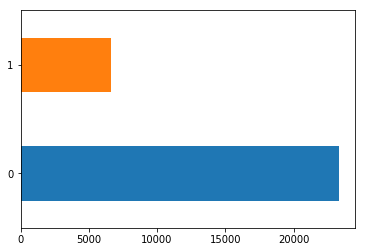

In [4]:
df['default.payment.next.month'].value_counts().plot(kind = "barh")
print(df['default.payment.next.month'].value_counts())

Examining the correlation heatmap, we can see that features are relatively uncorrelated except for bill_amt* and pay_* 

Regression algorithms seem appropriate

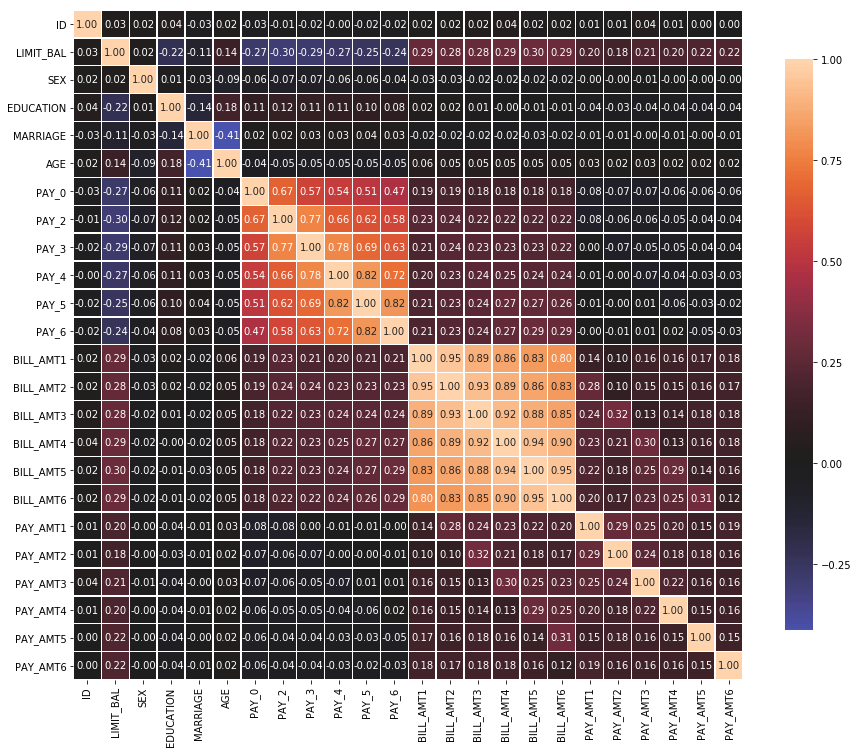

In [5]:
correlations = X.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

### Examining the distribution of variables
Specifically look at bill and pay

In [6]:
def draw_histograms(df, variables, n_rows, n_cols, n_bins):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=n_bins,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

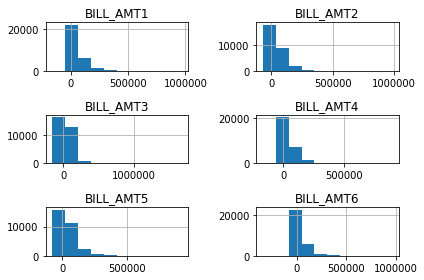

In [7]:
bills = df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
draw_histograms(bills, bills.columns, 3, 2, 10)

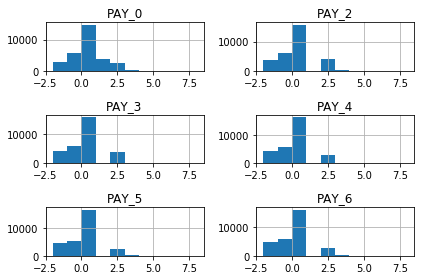

In [8]:
pays = df[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(pays, pays.columns, 3, 2, 10)

### Look at categorical variables for sparsity

Specifically looking at marriage and education

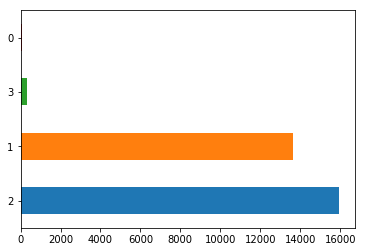

In [9]:
df.MARRIAGE.value_counts().plot(kind = "barh")

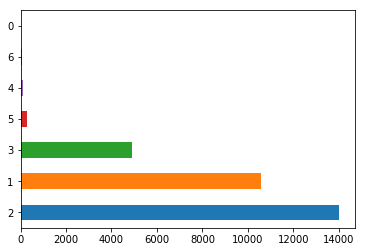

In [10]:
df.EDUCATION.value_counts().plot(kind = "barh")

Preliminary data cleaning:

To deal with the correlation issue, just drop Bill_AMT2 - Bill_AMT6 and PAY_2 - PAY_6 columns. The reason why we keep the first column is because it's August data

Because marriage = 0 can be classified as other set all 3s to 0

For Education: 0, 5, 6 can be considered as other and classified as 4

In [11]:
X.drop(['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'], axis=1, inplace=True)
X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000.0,2,2,1,24,2,3913.0,0.0,689.0,0.0,0.0,0.0,0.0
1,2,120000.0,2,2,2,26,-1,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,3,90000.0,2,2,2,34,0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,4,50000.0,2,2,1,37,0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,5,50000.0,1,2,1,57,-1,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


Looking at the correlation matrix again... 

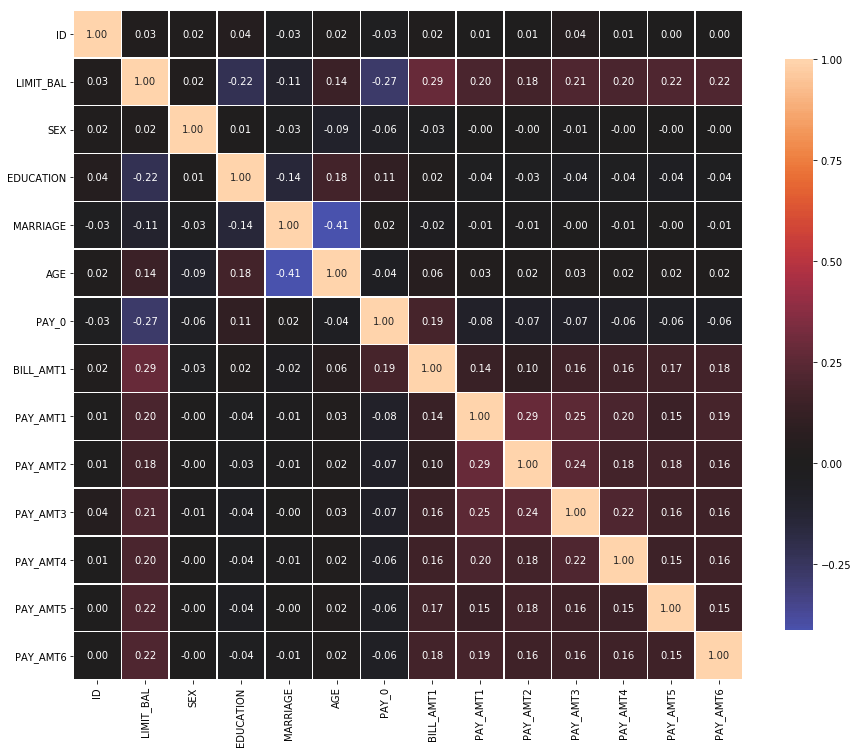

In [12]:
correlations = X.corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

Now clean up the education and marriage columns as described earlier

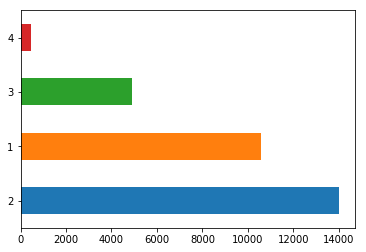

In [13]:
X.EDUCATION.replace([0,5,6],4,inplace=True)
X.EDUCATION.value_counts().plot(kind = "barh")

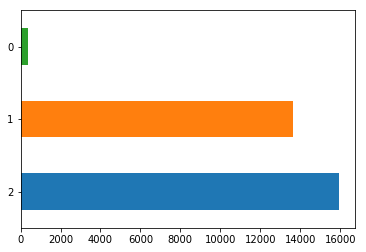

In [14]:
X.MARRIAGE.replace(3,0,inplace=True)
X.MARRIAGE.value_counts().plot(kind = "barh")

One-hot encode the categorical variables

In [15]:
X = pd.get_dummies(data=X, columns=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0'])


# Machine Learning

First iteration where we just run ML regression models on the raw unpreprocessed data and compare results after

## Random Forest

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5,random_state=0)

clf_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [17]:
y_pred_rf = clf_rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_acc

0.814

Since random forest has the highest accuracy score, below would be exploring what are the best parameters to improve the score

In [45]:
from sklearn.model_selection import GridSearchCV

In [55]:
param_grid = {
    "n_estimators":[50, 100, 200],
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10]
    }
#    

In [56]:
clf_gs = GridSearchCV(clf_rf, param_grid, cv=5)

In [57]:
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
y_pred_gs = clf_gs.predict(X_test)
gs_acc = accuracy_score(y_test, y_pred_gs)
gs_acc

0.8203333333333334

In [60]:
clf_gs.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 200}

In [68]:
y_pred_gs = clf_gs.predict(X_train)
gs_acc = accuracy_score(y_train, y_pred_gs)
gs_acc

0.8329583333333334

Since the accuracy score of tunned ramdom forest has improved, below would be exploring by using
the current parameters as the lower bounds and increase as well to see if the score could be improved

In [61]:
param_grid = {
    "n_estimators":[200, 300, 500],
    "criterion": ["entropy"],
    "max_depth": [10, 15, 20]
    }
#    

In [62]:
clf_gs2 = GridSearchCV(clf_rf, param_grid, cv=5)

In [63]:
clf_gs2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 300, 500], 'criterion': ['entropy'], 'max_depth': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
y_pred_gs2 = clf_gs2.predict(X_test)
gs2_acc = accuracy_score(y_test, y_pred_gs2)
gs2_acc

0.8198333333333333

In [67]:
y_pred_gs3 = clf_gs2.predict(X_train)
gs3_acc = accuracy_score(y_train, y_pred_gs3)
gs3_acc

0.963625

There's around 15% difference, OVERFITTING!!! let's see what how f1_score has to say.

In [70]:
from sklearn.metrics import f1_score

In [75]:
f1_score(y_test, y_pred_gs2) 

0.4419204956117707

## SVM

In [18]:
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [19]:
clf_svm= svm.SVC(gamma='scale')
clf_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
y_pred_svm = clf_svm.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
svm_acc

0.7798333333333334

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)

/Users/victoria/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
y_pred_lr = clf_lr.predict(X_test)
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_acc

0.7811666666666667

## Neural Network

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  

In [29]:
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Users/victoria/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/victoria/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/victoria/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [30]:
clf_mlp = MLPClassifier()
clf_mlp.fit(X_train, y_train)

/Users/victoria/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [32]:
y_pred_mlp = clf_mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred_mlp)
mlp_acc

0.8076666666666666

Trying to find the best parameters for MLP

In [89]:
param_grid_mlp = {
    "solver":['lbfgs', 'sgd'],
    "hidden_layer_sizes": [(100, 2),(100,3),(75,4)]
    }

In [90]:
clf_gs_mlp = GridSearchCV(clf_mlp, param_grid_mlp, cv=5)

In [91]:
clf_gs_mlp.fit(X_train, y_train)

/Users/victoria/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/victoria/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/victoria/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/victoria/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer:

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': ['lbfgs', 'sgd'], 'hidden_layer_sizes': [(100, 2), (100, 3), (75, 4)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [92]:
y_pred_gs_mlp = clf_gs_mlp.predict(X_test)

In [94]:
mlp_acc = accuracy_score(y_test, y_pred_gs_mlp)
mlp_acc

0.8188333333333333

In [95]:
f1_score(y_test, y_pred_gs_mlp) 

0.4370792335577421